In [7]:
import tensorflow as tf
import cProfile
import numpy as np

In [4]:
tf.executing_eagerly()

True

In [5]:
x = [[2.]]
m = tf.matmul(x,x)
print(m)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


In [18]:
a = tf.constant([[1,2], [3,4]])
print(a)

print('\n', a.numpy())

b = tf.add(a,1)
print('\n', b)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)

 [[1 2]
 [3 4]]

 tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [15]:
print(a*b)
print(np.multiply(a,b))
print(tf.multiply(a,b))

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)
[[ 2  6]
 [12 20]]
tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [22]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


## Gradient

In [26]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape: #tape에 정방향 연산 기록
  loss = w*w

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


## Model training

In [25]:
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.`newaxis`]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

11493376/11490434 [==============================] - 1s 0us/step


In [28]:
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, [3,3], activation='relu', input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)

])

In [29]:
# 즉시 실행에서는 훈련 전에 모델을 사용해 결과를 볼 수 있다. 
for images, labels in dataset.take(1):
  print(mnist_model(images[0:1]).numpy())

[[ 0.04109878  0.03908053 -0.05955648 -0.05716015 -0.05351461 -0.04207106
  -0.0372459  -0.01273214  0.0266578   0.00382484]]


In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

In [33]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    tf.debugging.assert_equal(logits.shape, (32, 10))
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [34]:
def train():
    for epoch in range(3):
      for(batch, (images, labels)) in enumerate(dataset):
        train_step(images, labels)
      print('epoch', epoch, ', end')

train()

epoch 0 , end
epoch 1 , end
epoch 2 , end


Text(0, 0.5, 'loss')

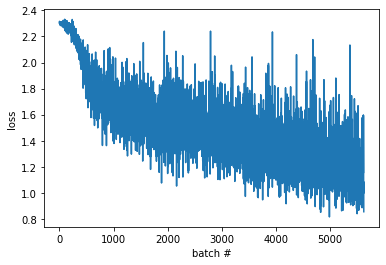

In [36]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('batch #')
plt.ylabel('loss')

In [37]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

In [38]:
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])


model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("early loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("step {:03d} loss: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("total loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

early loss: 70.981
step 000 loss: 68.137
step 020 loss: 30.294
step 040 loss: 13.789
step 060 loss: 6.580
step 080 loss: 3.428
step 100 loss: 2.047
step 120 loss: 1.441
step 140 loss: 1.175
step 160 loss: 1.058
step 180 loss: 1.007
step 200 loss: 0.984
step 220 loss: 0.974
step 240 loss: 0.969
step 260 loss: 0.967
step 280 loss: 0.966
total loss: 0.966
W = 2.9874134063720703, B = 1.9979201555252075


In [49]:
A =  np.array([1,2,3,4,5,6]).reshape(2,3)
print(A)
print(np.mean(A), A.mean())

print(tf.reduce_mean(A))

[[1 2 3]
 [4 5 6]]
3.5 3.5
tf.Tensor(3, shape=(), dtype=int32)
